# Brain Tumor Detection - Train Lightweight Models

Train 3 ultra-lightweight models optimized for speed and efficiency.

**Models to Train:**
1. Fast-SCNN (~1.08M parameters) - Fast Semantic Segmentation
2. BiSeNetV2 (~1.43M parameters) - Bilateral Segmentation Network V2
3. SegNeXt (~2.59M parameters) - Segmentation with Convolutional Attention

All models have <3M parameters for real-time inference.


## 1. Setup and Imports

In [1]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import json
from datetime import datetime

sys.path.append('src')

import config
from models import get_model
from datasets.brain_tumor_dataset import get_dataloaders
from losses.combined_loss import MultiTaskLoss
from utils.metrics import calculate_classification_metrics, calculate_iou, count_parameters

print("✓ Imports successful")
print(f"Device: {config.DEVICE}")

/home/siu856569517/.conda/envs/brain_tumor/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Imports successful
Device: cuda


In [2]:
# Global Training Settings
BATCH_SIZE = 8
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
EARLY_STOPPING_PATIENCE = 10
RESUME_TRAINING = True

# Lightweight models to train
MODELS_TO_TRAIN = [
    'fast_scnn',
    'bisenetv2',
    'segnext'
]

print(f"Training Configuration:")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Resume Training: {RESUME_TRAINING}")
print(f"  Lightweight models to train: {', '.join(MODELS_TO_TRAIN)}")
print(f"  Device: {config.DEVICE}")

Training Configuration:
  Batch Size: 8
  Epochs: 50
  Resume Training: True
  Lightweight models to train: fast_scnn, bisenetv2, segnext
  Device: cuda


In [3]:
print("Loading datasets...")
train_loader, val_loader, test_loader = get_dataloaders(
    train_dir=config.TRAIN_DIR,
    val_dir=config.VAL_DIR,
    test_dir=config.TEST_DIR,
    train_ann=config.TRAIN_ANNOTATIONS,
    val_ann=config.VAL_ANNOTATIONS,
    test_ann=config.TEST_ANNOTATIONS,
    batch_size=BATCH_SIZE,
    num_workers=config.NUM_WORKERS,
    image_size=config.IMAGE_SIZE
)

print(f"✓ Data loaded")
print(f"  Train: {len(train_loader)} batches ({len(train_loader)*BATCH_SIZE} images)")
print(f"  Val: {len(val_loader)} batches")
print(f"  Test: {len(test_loader)} batches")

Loading datasets...
✓ Data loaded
  Train: 188 batches (1504 images)
  Val: 54 batches
  Test: 27 batches


## 5. Training Function

In [4]:
def train_model(model_name, num_epochs=NUM_EPOCHS, resume=RESUME_TRAINING):
    """
    Train a single model with live visualization and resume support
    """
    print(f"\n{'='*60}")
    print(f"Training: {model_name.upper()}")
    print(f"{'='*60}")
    
    # Initialize model
    model = get_model(
        model_name=model_name,
        n_classes_seg=config.SEGMENTATION_CLASSES,
        n_classes_cls=config.NUM_CLASSES - 1,
        img_size=config.IMAGE_SIZE
    ).to(config.DEVICE)
    
    num_params = count_parameters(model)
    print(f"Parameters: {num_params:,} ({num_params/1e6:.2f}M)")
    
    # Loss, optimizer, scheduler
    criterion = MultiTaskLoss(
        classification_weight=config.CLASSIFICATION_WEIGHT,
        segmentation_weight=config.SEGMENTATION_WEIGHT
    )
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    # History
    history = {
        'train_loss': [], 'val_loss': [],
        'train_cls_acc': [], 'val_cls_acc': [],
        'train_seg_iou': [], 'val_seg_iou': []
    }
    
    best_val_loss = float('inf')
    patience_counter = 0
    start_epoch = 1
    os.makedirs(config.CHECKPOINT_DIR, exist_ok=True)
    
    # Resume from checkpoint if available
    checkpoint_path = f'{config.CHECKPOINT_DIR}/{model_name}_best.pth'
    history_path = f'{config.RESULTS_DIR}/{model_name}_history.json'
    
    if resume and os.path.exists(checkpoint_path):
        print(f"Resuming from checkpoint: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=config.DEVICE, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        
        if 'optimizer_state_dict' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if 'scheduler_state_dict' in checkpoint:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
        best_val_loss = checkpoint['val_loss']
        start_epoch = checkpoint['epoch'] + 1
        
        if os.path.exists(history_path):
            with open(history_path, 'r') as f:
                history = json.load(f)
            print(f"Loaded training history: {len(history['train_loss'])} epochs completed")
        
        print(f"Resuming from epoch {start_epoch}")
        print(f"Best Val Loss so far: {best_val_loss:.4f}")
    else:
        print("Starting training from scratch")
    
    # Training loop
    for epoch in range(start_epoch, num_epochs + 1):
        # ===== TRAIN =====
        model.train()
        train_loss = 0.0
        all_cls_preds, all_cls_targets = [], []
        all_seg_preds, all_seg_targets = [], []
        
        for batch in train_loader:
            images = batch['image'].to(config.DEVICE)
            seg_masks = batch['segmentation_mask'].to(config.DEVICE)
            cls_labels = batch['classification_label'].to(config.DEVICE)
            
            optimizer.zero_grad()
            cls_output, seg_output = model(images)
            loss_dict = criterion(cls_output, seg_output, cls_labels, seg_masks)
            loss = loss_dict['total_loss']
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            all_cls_preds.append(torch.argmax(cls_output, dim=1).cpu())
            all_cls_targets.append(cls_labels.cpu())
            all_seg_preds.append(torch.argmax(seg_output, dim=1).cpu())
            all_seg_targets.append(seg_masks.cpu())
        
        train_loss /= len(train_loader)
        train_cls_acc = calculate_classification_metrics(
            torch.cat(all_cls_preds), torch.cat(all_cls_targets)
        )['accuracy']
        train_seg_iou = calculate_iou(
            torch.cat(all_seg_preds), torch.cat(all_seg_targets), num_classes=2
        )
        
        # ===== VALIDATE =====
        model.eval()
        val_loss = 0.0
        all_cls_preds, all_cls_targets = [], []
        all_seg_preds, all_seg_targets = [], []
        
        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(config.DEVICE)
                seg_masks = batch['segmentation_mask'].to(config.DEVICE)
                cls_labels = batch['classification_label'].to(config.DEVICE)
                
                cls_output, seg_output = model(images)
                loss_dict = criterion(cls_output, seg_output, cls_labels, seg_masks)
                val_loss += loss_dict['total_loss'].item()
                
                all_cls_preds.append(torch.argmax(cls_output, dim=1).cpu())
                all_cls_targets.append(cls_labels.cpu())
                all_seg_preds.append(torch.argmax(seg_output, dim=1).cpu())
                all_seg_targets.append(seg_masks.cpu())
        
        val_loss /= len(val_loader)
        val_cls_acc = calculate_classification_metrics(
            torch.cat(all_cls_preds), torch.cat(all_cls_targets)
        )['accuracy']
        val_seg_iou = calculate_iou(
            torch.cat(all_seg_preds), torch.cat(all_seg_targets), num_classes=2
        )
        
        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_cls_acc'].append(train_cls_acc)
        history['val_cls_acc'].append(val_cls_acc)
        history['train_seg_iou'].append(train_seg_iou)
        history['val_seg_iou'].append(val_seg_iou)
        
        scheduler.step(val_loss)
        
        # ===== LIVE PLOT =====
        if epoch % 5 == 0 or epoch == 1:  # Update plot every 5 epochs
            clear_output(wait=True)
            
            fig, axes = plt.subplots(1, 3, figsize=(15, 4))
            fig.suptitle(f'{model_name.upper()} - Epoch {epoch}/{num_epochs}', fontsize=14, fontweight='bold')
            
            axes[0].plot(history['train_loss'], 'b-o', label='Train', linewidth=2)
            axes[0].plot(history['val_loss'], 'r-s', label='Val', linewidth=2)
            axes[0].set_xlabel('Epoch')
            axes[0].set_ylabel('Loss')
            axes[0].set_title('Loss')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)
            
            axes[1].plot(history['train_cls_acc'], 'b-o', label='Train', linewidth=2)
            axes[1].plot(history['val_cls_acc'], 'r-s', label='Val', linewidth=2)
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel('Accuracy')
            axes[1].set_title('Classification Accuracy')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
            
            axes[2].plot(history['train_seg_iou'], 'b-o', label='Train', linewidth=2)
            axes[2].plot(history['val_seg_iou'], 'r-s', label='Val', linewidth=2)
            axes[2].set_xlabel('Epoch')
            axes[2].set_ylabel('Mean IoU')
            axes[2].set_title('Segmentation IoU')
            axes[2].legend()
            axes[2].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
        
        # Print progress
        print(f"Epoch {epoch:3d}/{num_epochs} | Loss: {train_loss:.4f}/{val_loss:.4f} | "
              f"Acc: {train_cls_acc:.4f}/{val_cls_acc:.4f} | IoU: {train_seg_iou:.4f}/{val_seg_iou:.4f}", end='')
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_cls_acc,
                'val_iou': val_seg_iou
            }, f'{config.CHECKPOINT_DIR}/{model_name}_best.pth')
            print(" ✓ BEST", end='')
            patience_counter = 0
        else:
            patience_counter += 1
        print()
        
        # Save intermediate checkpoint every 5 epochs
        if epoch % 5 == 0:
            os.makedirs(config.RESULTS_DIR, exist_ok=True)
            with open(f'{config.RESULTS_DIR}/{model_name}_history.json', 'w') as f:
                json.dump(history, f, indent=4)
        
        # Early stopping
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print(f"\n⚠ Early stopping at epoch {epoch}")
            break
    
    # Save history
    os.makedirs(config.RESULTS_DIR, exist_ok=True)
    with open(f'{config.RESULTS_DIR}/{model_name}_history.json', 'w') as f:
        json.dump(history, f, indent=4)
    
    print(f"\n✓ {model_name.upper()} training completed!")
    print(f"  Best Val Loss: {best_val_loss:.4f}")
    print(f"  Parameters: {num_params/1e6:.2f}M")
    
    return history, best_val_loss, num_params

## 6. Resume Training

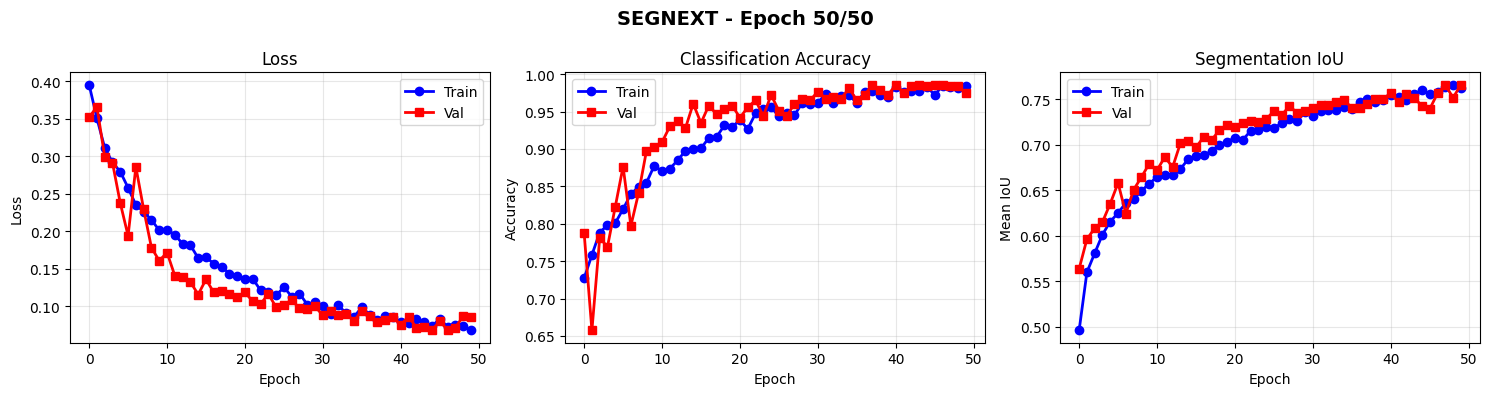

Epoch  50/50 | Loss: 0.0676/0.0851 | Acc: 0.9840/0.9744 | IoU: 0.7628/0.7663

✓ SEGNEXT training completed!
  Best Val Loss: 0.0682
  Parameters: 2.59M

------------------------------------------------------------


✓ Training completed!
Finished at: 2025-11-30 01:04:40


In [5]:
# Store results for comparison
all_results = {}

print(f"\nResuming/Starting training of {len(MODELS_TO_TRAIN)} model(s)...")
print(f"Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

for model_name in MODELS_TO_TRAIN:
    history, best_loss, num_params = train_model(model_name, num_epochs=NUM_EPOCHS, resume=RESUME_TRAINING)
    all_results[model_name] = {
        'history': history,
        'best_val_loss': best_loss,
        'parameters': num_params
    }
    print(f"\n{'-'*60}\n")

print(f"\n✓ Training completed!")
print(f"Finished at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

## 7. Training Results Visualization


Comparison plot saved to results/model_comparison.png


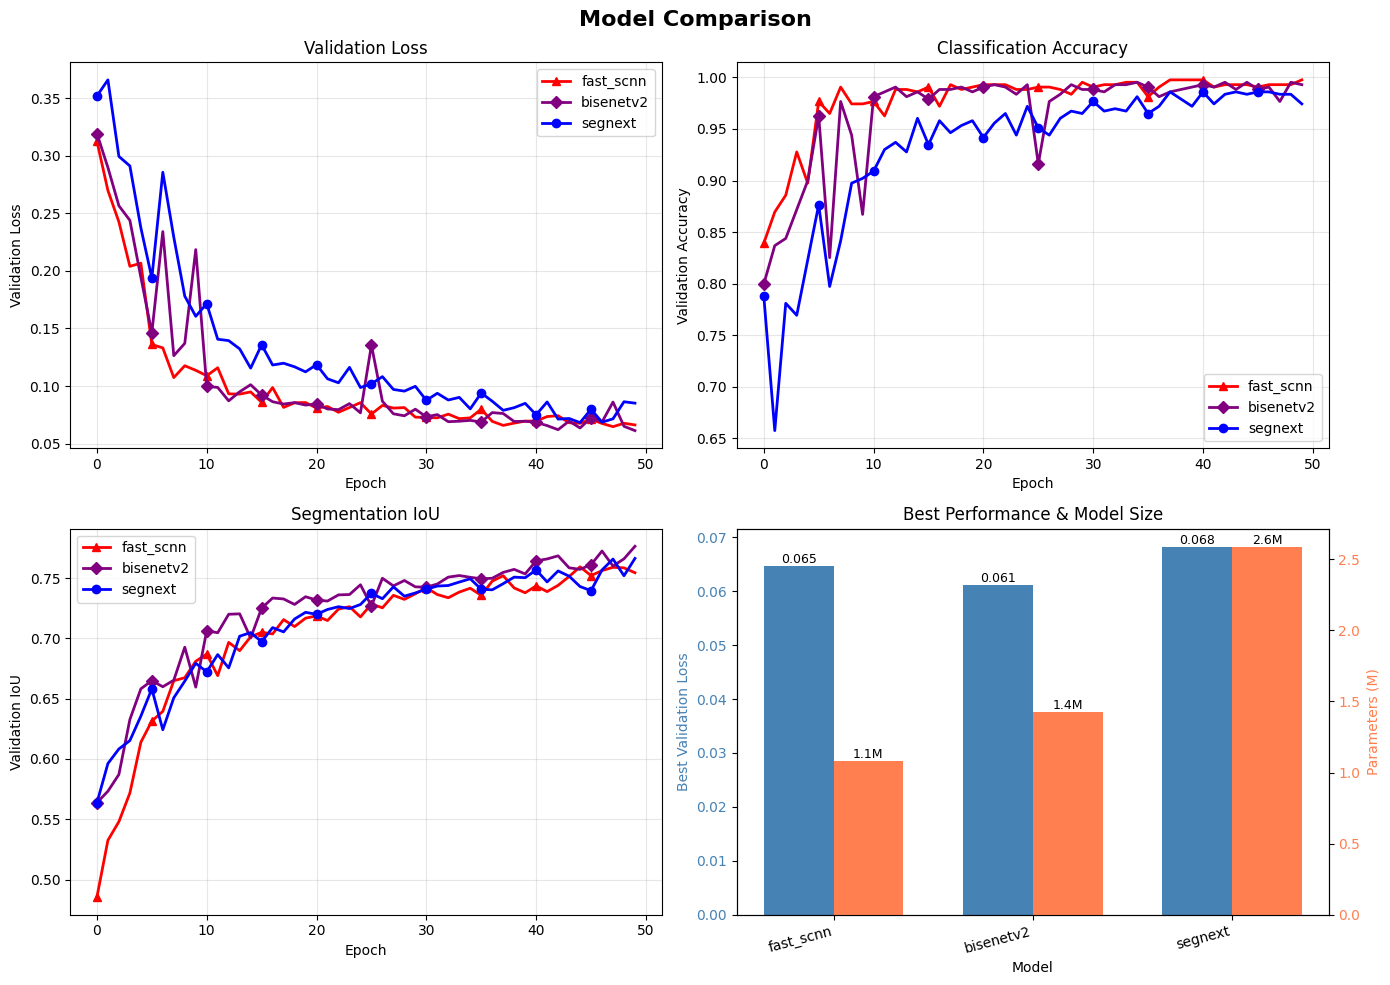

In [6]:
# Comparison plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
model_count = len(all_results)
if model_count == 1:
    fig.suptitle(f'{list(all_results.keys())[0].upper()} - Training Results', fontsize=16, fontweight='bold')
else:
    fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')

colors = ['red', 'purple', 'blue', 'green', 'orange']
markers = ['^', 'D', 'o', 's', 'v']

# Validation Loss
for idx, (model_name, results) in enumerate(all_results.items()):
    axes[0, 0].plot(results['history']['val_loss'], 
                    label=model_name, color=colors[idx], marker=markers[idx], 
                    markevery=5, linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Validation Loss')
axes[0, 0].set_title('Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Validation Accuracy
for idx, (model_name, results) in enumerate(all_results.items()):
    axes[0, 1].plot(results['history']['val_cls_acc'], 
                    label=model_name, color=colors[idx], marker=markers[idx],
                    markevery=5, linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Validation Accuracy')
axes[0, 1].set_title('Classification Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Validation IoU
for idx, (model_name, results) in enumerate(all_results.items()):
    axes[1, 0].plot(results['history']['val_seg_iou'], 
                    label=model_name, color=colors[idx], marker=markers[idx],
                    markevery=5, linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Validation IoU')
axes[1, 0].set_title('Segmentation IoU')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Bar chart: Best results
model_names = list(all_results.keys())
best_losses = [all_results[m]['best_val_loss'] for m in model_names]
params_m = [all_results[m]['parameters']/1e6 for m in model_names]

x = np.arange(len(model_names))
width = 0.35

ax2 = axes[1, 1]
bars1 = ax2.bar(x - width/2, best_losses, width, label='Best Val Loss', color='steelblue')
ax2.set_ylabel('Best Validation Loss', color='steelblue')
ax2.set_xlabel('Model')
ax2.set_title('Best Performance & Model Size')
ax2.set_xticks(x)
ax2.set_xticklabels(model_names, rotation=15, ha='right')
ax2.tick_params(axis='y', labelcolor='steelblue')

ax2_twin = ax2.twinx()
bars2 = ax2_twin.bar(x + width/2, params_m, width, label='Parameters (M)', color='coral')
ax2_twin.set_ylabel('Parameters (M)', color='coral')
ax2_twin.tick_params(axis='y', labelcolor='coral')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax2_twin.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.1f}M', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
if len(all_results) == 1:
    model_name = list(all_results.keys())[0]
    plt.savefig(f'{config.RESULTS_DIR}/{model_name}_training_results.png', dpi=300, bbox_inches='tight')
    print(f"\nTraining plot saved to results/{model_name}_training_results.png")
else:
    plt.savefig(f'{config.RESULTS_DIR}/model_comparison.png', dpi=300, bbox_inches='tight')
    print("\nComparison plot saved to results/model_comparison.png")
plt.show()

## 8. Summary Table

In [ ]:
import pandas as pd

# Create summary table
summary_data = []
for model_name, results in all_results.items():
    history = results['history']
    summary_data.append({
        'Model': model_name,
        'Parameters (M)': f"{results['parameters']/1e6:.2f}",
        'Best Val Loss': f"{results['best_val_loss']:.4f}",
        'Final Val Acc': f"{history['val_cls_acc'][-1]:.4f}",
        'Final Val IoU': f"{history['val_seg_iou'][-1]:.4f}",
        'Epochs Trained': len(history['val_loss'])
    })

df = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("TRAINING RESULTS SUMMARY")
print("="*80)
print(df.to_string(index=False))
print("="*80)

# Save to CSV
if len(all_results) == 1:
    model_name = list(all_results.keys())[0]
    df.to_csv(f'{config.RESULTS_DIR}/{model_name}_training_summary.csv', index=False)
    print(f"\n✓ Summary saved to {config.RESULTS_DIR}/{model_name}_training_summary.csv")
else:
    df.to_csv(f'{config.RESULTS_DIR}/training_summary.csv', index=False)
    print(f"\n✓ Summary saved to {config.RESULTS_DIR}/training_summary.csv")

# Show model details
if len(all_results) > 0:
    best_model = min(all_results.items(), key=lambda x: x[1]['best_val_loss'])
    if len(all_results) == 1:
        print(f"\nMODEL: {best_model[0].upper()}")
    else:
        print(f"\nBEST MODEL: {best_model[0].upper()}")
    print(f"   Best Val Loss: {best_model[1]['best_val_loss']:.4f}")
    print(f"   Final Val Acc: {best_model[1]['history']['val_cls_acc'][-1]:.4f}")
    print(f"   Final Val IoU: {best_model[1]['history']['val_seg_iou'][-1]:.4f}")
    print(f"   Parameters: {best_model[1]['parameters']/1e6:.2f}M")
    print(f"   Epochs: {len(best_model[1]['history']['val_loss'])}")

print(f"\nNote: Compare all models using test_and_visualize_notebook.ipynb")


TRAINING RESULTS SUMMARY
    Model Parameters (M) Best Val Loss Final Val Acc Final Val IoU  Epochs Trained
fast_scnn           1.08        0.0647        0.9977        0.7545              50
bisenetv2           1.43        0.0613        0.9930        0.7764              50
  segnext           2.59        0.0682        0.9744        0.7663              50

✓ Summary saved to results/training_summary.csv

BEST MODEL: BISENETV2
   Best Val Loss: 0.0613
   Final Val Acc: 0.9930
   Final Val IoU: 0.7764
   Parameters: 1.43M
   Epochs: 50

Note: Compare all models using test_and_visualize_notebook.ipynb


: 